In [1]:
import nbsetup
import torch
import math
import matplotlib.pyplot as plt

# ICP

Intracranial pressure (ICP) is measured by lumbar puncture during infusion tests, at a sampling frequency $f_s \simeq 100 Hz$.

### Reading infusion tests

In [269]:
import icp.loader as hdf5
f = hdf5.File(0)

> loaded 600 points at 100 Hz:


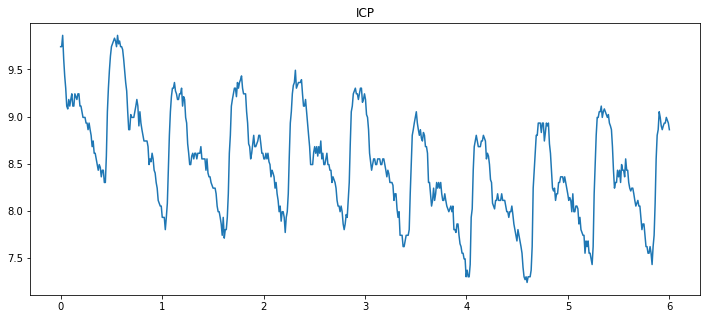

In [270]:
N = 600
fs = 100 
icp = f.icp(N)
t = torch.linspace(0, N/fs, N)

plt.figure(figsize=(12, 5))
plt.plot(t, icp)
plt.title('ICP')
print(f'> loaded {N} points at 100 Hz:')

## Heat Kernels

In the following we use the heat operator ${\mathrm e}^{-t \Delta}$ to denoise the ICP signal. Heat operators are generated by integrating the heat equation: 
$$ \frac {\partial f}{\partial t} = - \Delta f $$

They act on $f: [0, T] \to \mathbb{R}$ by convolution with a gaussian kernel, representing transport during a time $t$ by a Brownian motion leaving from each point of $[0, T]$. 

$$ \big( {\mathrm e}^{- t \Delta} \cdot f \big)(x) = \mathbb{E}_{s \sim \mathcal{N}(0, t)}[ f(x + s) ] $$

Below, we use the effect of applying a heat kernel of range much shorter than the fundamental wave length to filter noisy frequencies of the ICP signal, _without resorting to fast Fourier transforms_. Implemented as short-range convolutions, heat kernels are fast operators preserving the temporal consistency of the signal, free of aliasing defaults often associated with spectral filters. 

Text(0.5, 1.0, 'ICP')

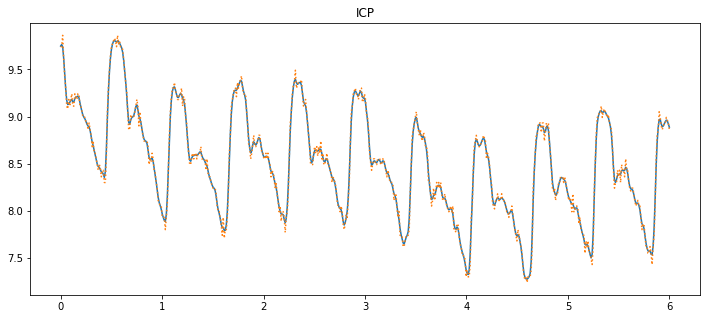

In [271]:
from sig.filter import Heat

kernel = Heat(1.1)

icp_f = kernel(icp)

"""Plot"""
plt.figure(figsize=(12, 5))
plt.plot(t, icp_f)
plt.plot(t, icp, linestyle='dotted')
plt.title("ICP")

### Segmentation

Instead of detecting first derivative peaks, which leads to temporal offsets in segmented pulses, one can apply a large heat kernel to absorb small peaks and troughs, keeping only fundamental cardiac oscillations.

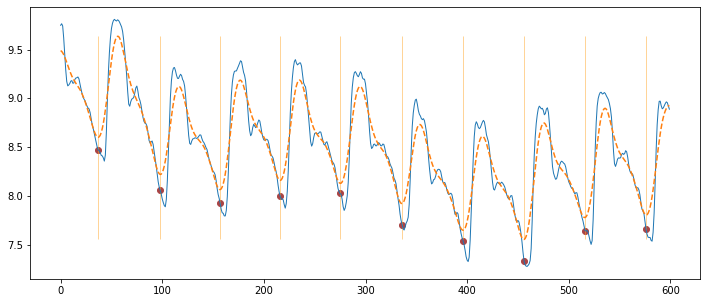

In [272]:
from scipy.signal import find_peaks

icp0 = Heat(6)(icp_f)

peaks = find_peaks(- icp0, distance=30)[0]

plt.figure(figsize=(12, 5))
plt.plot(icp_f, linewidth=1)
plt.plot(icp0, linestyle="dashed", linewidth=1.5)

plt.scatter(peaks, [icp_f[i] for i in peaks], color="#a44")
plt.vlines(peaks, min(icp0), max(icp0), color="#fa3", linewidth=0.5)

Note that diffusion can slightly move peaks horizontally, although it has the advantage of efficiently filtering out peaks of small magnitude. We can use the remaining peaks as starting point for another peak detection on the steeper signal. 

_N.B. It seems that extracting a typical pulse shape would benefit from time alignment of various features, e.g. metric invariant under reparameterisations. Otherwise subordinate peaks are flattened by the averaging process._

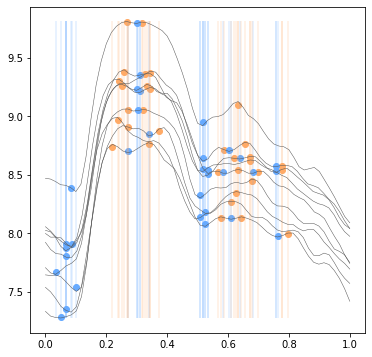

In [273]:
segments = [icp_f[t:peaks[i+1]] for i, t in enumerate(peaks[:-1])]
pmin, pmax = min(icp_f), max(icp_f)

def plot_peaks(x, y, color="#fa6", sign=1, yrange=None):
    if y == None:
        y = x
        x = torch.linspace(0, 1, y.shape[0])
    if not yrange:
        yrange = (min(y), max(y))
    pks = find_peaks(sign * y)[0]
    plt.scatter([x[i] for i in pks], [y[i] for i in pks], color=color)
    plt.vlines([x[i] for i in pks], yrange[0], yrange[1], color=color, linewidth=0.3)
    
plt.figure(figsize=(6, 6))
for s in segments: 
    x = torch.linspace(0, 1, len(s))
    plt.plot(x, s, color="#555", linewidth=0.5)
    # Segment peaks 
    s_reg = Heat(1)(s)
    plot_peaks(x, s_reg, "#fa6", yrange=(pmin, pmax))
    plot_peaks(x, s_reg, "#6af", -1, yrange=(pmin, pmax))

# First Derivative

The regularising effect of the Heat kernel is also quite remarkable on the first derivative of the signal.

We will use peaks in the derivative signal to segment different pulses at systolic maximal icp variation. 


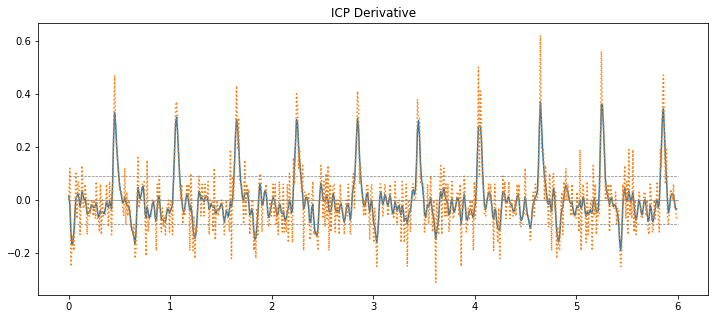

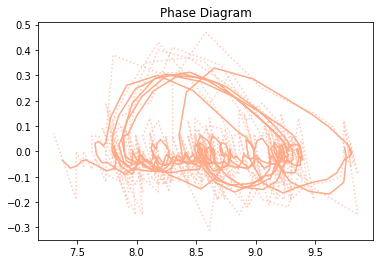

In [277]:
plt.figure(figsize=(12, 5))
plt.title('ICP Derivative')


"""Plot ICP"""
dp = torch.diff(icp_f)
plt.plot(t[:-1], dp)
plt.plot(t[:-1], torch.diff(icp), linestyle="dotted")
plt.plot(t, torch.zeros(t.shape), color="grey", linewidth=0.7)

"""Plot variance"""
sigma = torch.sqrt(torch.var(dp))
plt.plot((t[0], t[-1]), (sigma, sigma), color='grey', linestyle="dashed", lw=0.7)
plt.plot((t[0], t[-1]), (-sigma, -sigma), color='grey', linestyle="dashed", lw=0.7)

"""Phase Diagram"""
plt.figure(figsize=(6, 4))
N = 400
plt.title("Phase Diagram")
plt.plot(icp[:N], torch.diff(icp)[:N], color="#fcb", linestyle="dotted")
plt.plot(icp_f[:N], torch.diff(icp_f)[:N], color="#fa8")


### Peak detection

We'll filter derivative peaks of amplitude larger than standard-deviation to time systolic events. 

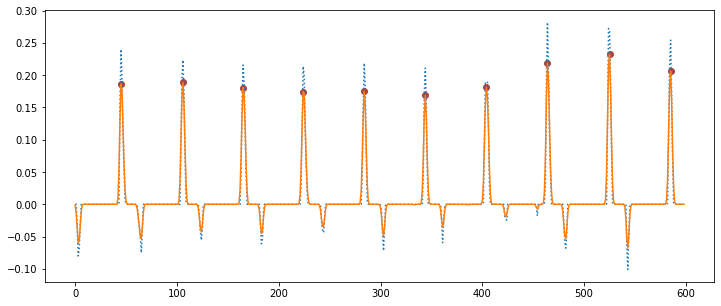

In [278]:
def retract(t):
    s = torch.sqrt(torch.var(t))
    return t - torch.min(torch.max(t, -s), s)

dpHigh = retract(dp)
plt.figure(figsize=(12, 5))
plt.plot(dpHigh, linestyle="dotted")
plt.plot(Heat(1)(dpHigh))

"""Peaks"""

import scipy
from scipy.signal import find_peaks

distance=30
peaks = find_peaks(Heat(1.2)(dpHigh), height=0.02, distance=distance)
peaks = [peaks[0], peaks[1]['peak_heights']]
plt.scatter(peaks[0], peaks[1], color="#a44")

### Segmentation

With peaks detected we can segment different pulses to gather an average typical pulse.

This will require to chose an upsampling strategy as all pulses do not have the same number of points.

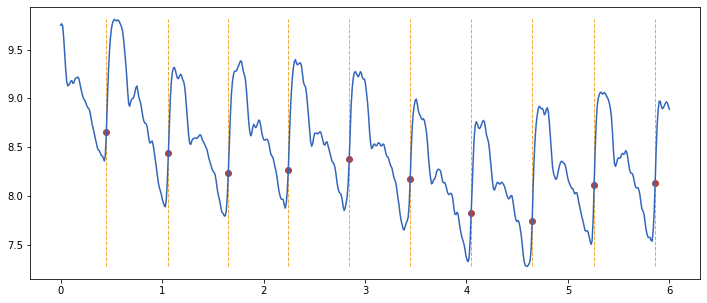

In [279]:
onsets = peaks[0]
tpeaks = [t[i] for i in onsets]

plt.figure(figsize=(12, 5))
plt.plot(t, icp_f, color="#36b")

plt.scatter(tpeaks, [icp_f[i] for i in onsets], color="#a44")
plt.vlines(tpeaks, min(icp_f), max(icp_f), color="#ea3", linestyle="dashed", linewidth=1)

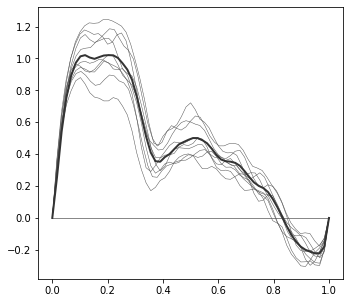

In [280]:
segments = [icp_f[t:onsets[i+1]] for i, t in enumerate(onsets[:-1])]

def rotate(t): 
    N = t.shape[0]
    x = torch.linspace(0, 1, N)
    slope = t[-1] - t[0]
    t = t - t[0] - slope * x
    return t 

def rescale(t):
    return t / torch.sqrt(torch.var(t))

def resample(y, N):
    M = y.shape[0]
    x = torch.linspace(0, 1, N)
    z = torch.zeros(x.shape)
    for i, xi in enumerate(x):
        z[i] = y[math.floor(xi * (M - 1))]
    return z

"""Pulses"""
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for s in segments: 
    x = torch.linspace(0, 1, len(s))
    plt.hlines([0], 0, 1, color="#888", linewidth=0.5)
    plt.plot(x, rotate(s), color="#555", linewidth=0.5)
   
"""Average Pulse"""
M = 60
pulse = torch.zeros((M,))
tpulse = torch.linspace(0, 1, M)

for s in segments:
    pulse += resample(rotate(s), M) / len(segments)

plt.plot(tpulse, pulse, color="#333", linewidth=2)

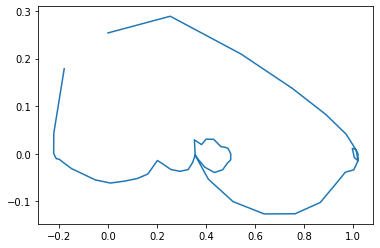

In [281]:
plt.plot(pulse[:-1], torch.diff(pulse))

### Second Derivative 
The second derivative of the signal as well is also made particularly clean and smooth. 

_N.B._ In the continuous and infinite dimensional case, one has $\mathrm{e}^{- t \Delta}: L^1([0, T]) \to C^\infty([0, T])$.

Text(0.5, 1.0, 'ICP 2nd Derivative')

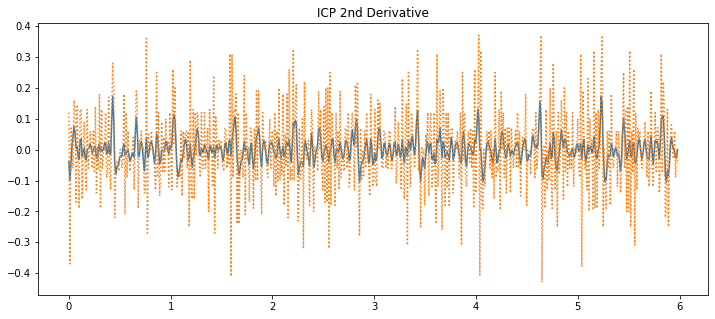

In [282]:
diff2 = lambda t: torch.diff(torch.diff(t))

plt.figure(figsize=(12, 5))
plt.plot(t[:-2], diff2(icp_f))
plt.plot(t[:-2], diff2(icp), linestyle="dotted")
plt.title('ICP 2nd Derivative')


We can leverage on the smoothness of this second order signal to detect "peaks" P1, P2, P3 and the like, even when they are not manifested by true local maxima but only separate different inflexions.

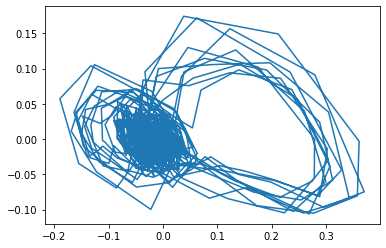

In [283]:
plt.plot(torch.diff(icp_f)[:-1], diff2(icp_f))

## Spectral Analysis

In [35]:
from torch.fft import fft, ifft, rfft, irfft

<BarContainer object of 240 artists>

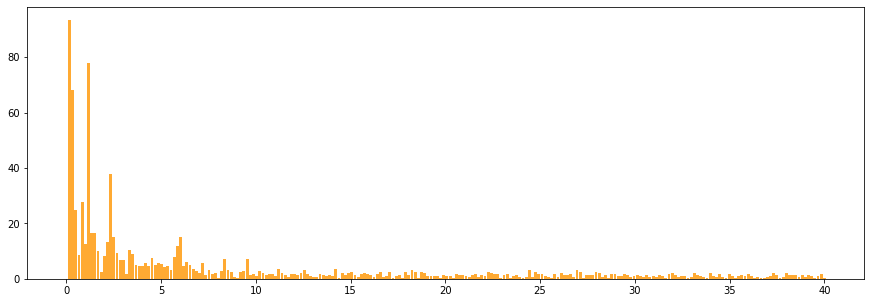

In [36]:
def center(tensor): 
    return tensor - tensor.mean()

def fourier(tensor, f1, fmax=100):
    N = tensor.shape[0]
    return rfft(center(tensor))[:math.floor(N * f1 /(2 * fmax))]

def spectrum(tensor, fcut): 
    return torch.linspace(0, fcut / 2, tensor.shape[0])

fcut = 80
_icp = fourier(icp, fcut)
_icp_f = fourier(icp_f, fcut)
sp = spectrum(_icp, fcut)

plt.figure(figsize=(15, 5))
plt.bar(sp, _icp_f.abs(), width=0.15)
plt.bar(sp, _icp.abs(), color="#fa3", linestyle="dotted", width=0.15)


Note that the spectral filter associated to the heat kernel does not vanish on high frequencies, as they persist to enforce counter aliasing. 